In [70]:
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据
# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集


In [61]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# 便准化数据（聚类前通常需要标准化）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled

聚类评估指标介绍

以下是三种常用的聚类效果评估指标，分别用于衡量聚类的质量和簇的分离与紧凑程度：

1.轮廓系数（Silhouette Score）

    定义：轮廓系数衡量每个样本与其所属簇的紧密程度

    取值范围[-1,1]

    轮廓系数越接近1，表示样本与其所属簇内其他样本很近，与其他簇很远，聚类效果越好

    轮廓系数越接近-1，表示样本与其所属簇内样本较远，与其他簇较近，聚类效果越差（可能被错误分类）。

    轮廓系数接近0，表示样本在簇边界附近，聚类效果无明显好坏。

    使用建议：选择轮廓系数最高的K值作为最佳簇数量。

2.CH指数（Calinski-Harabasz Index）

    定义：CH指数是簇间分散度与簇内分散度之比，用于评估簇的分离度和紧凑度。

    取值范围：[0,+∞）

    CH值越大，表示簇间分散度越高，簇内紧凑度越高，聚类效果越好。

    没有固定的上限，值越大越好。

    使用建议：选择CH指数最高的K值作为最佳簇数量

3.DB指数（Davies-Bouldin Index）

    定义：DB指数衡量簇间距离与簇内分散度的比值，用于评估簇的分离度和紧凑度。

    取值范围：[0,+∞）

    DB指数越小，表示簇间分离度越高，簇内紧凑度越高，聚类效果越好。

    没有固定的上限，值越小越好。

    使用建议：选择DB指数最低的K值最佳簇数量。

KMeans 聚类

算法原理

KMeans 是一种基于距离的聚类算法，需要预先指定聚类个数，即K。其核心步骤如下：

    1. 随机选择 `k` 个样本点作为初始质心（簇中心）。

    2. 计算每个样本点到各个质心的距离，将样本点分配到距离最近的质心所在的簇。

    3. 更新每个簇的质心为该簇内所有样本点的均值。
    
    4. 重复步骤 2 和 3，直到质心不再变化或达到最大迭代次数为止。

### 确定簇数的方法：肘部法
- **肘部法（Elbow Method）** 是一种常用的确定 `k` 值的方法。
- 原理：通过计算不同 `k` 值下的簇内平方和（Within-Cluster Sum of Squares, WCSS），绘制 `k` 与 WCSS 的关系图。
- 选择标准：在图中找到“肘部”点，即 WCSS 下降速率明显减缓的 `k` 值，通常认为是最佳簇数。这是因为增加 `k` 值带来的收益（WCSS 减少）在该点后变得不显著。

### KMeans 算法的优缺点
#### 优点
- **简单高效**：算法实现简单，计算速度快，适合处理大规模数据集。
- **适用性强**：对球形或紧凑的簇效果较好，适用于特征空间中簇分布较为均匀的数据。
- **易于解释**：聚类结果直观，簇中心具有明确的物理意义。

#### 缺点
- **需预先指定 `k` 值**：对簇数量 `k` 的选择敏感，不合适的 `k` 会导致聚类效果较差。
- **对初始质心敏感**：初始质心的随机选择可能导致结果不稳定或陷入局部最优（可通过 KMeans++ 初始化方法缓解）。
- **对噪声和异常值敏感**：异常值可能会显著影响质心的位置，导致聚类结果失真。
- **不适合非球形簇**：对非线性可分或形状复杂的簇效果较差，无法处理簇密度不均的情况。

DBSCAN聚类

In [62]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# 评估不同eps 和min_samples 下的指标
# eps这个参数表式邻域的半径，min_samples表示一个点被认为式核心点所需要的最小样本数。
# min_samples这个参数表示一个核心点所需的最小样本数。

eps_range = np.arange(0.3, 0.8, 0.1)   
# 测试eps从0.3到0.7
min_samples_range = range(3,8)
# 测试min_samples从3-7
results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps = eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        # 计算簇的数量（排除噪声点-1）
        n_clusters = len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        # 计算噪声点数量
        n_noise = list(dbscan_labels).count(-1)
        # 只有当簇数量大于1 且有 有效簇时才计算评估指标
        if n_clusters > 1:
            #排除噪声点后计算评估指标
            mask = dbscan_labels != -1
            if mask.sum() > 0 :     #确保有非噪声点
                silhouette = silhouette_score(X_scaled[mask],dbscan_labels[mask])
                ch = calinski_harabasz_score(X_scaled[mask],dbscan_labels[mask])
                db = davies_bouldin_score(X_scaled[mask],dbscan_labels[mask])
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': silhouette,
                    'ch_score': ch,
                    'db_score': db
                })
                print(f"eps={eps:.1f},min_samples={min_samples},簇数：{n_clusters},噪声点：{n_noise}",
                      f"轮廓系数：{silhouette:.3f},CH 指数：{ch:.2f},DB指数:{db:.3f}")
        else:
            print(f"eps = {eps:.1f},min_samples={min_samples},簇数：{n_clusters},噪声点：{n_noise},无法计算评估指标")
# 将结果转化为DataFrame 以便于可视化和选择参数
results_df = pd.DataFrame(results)

eps = 0.3,min_samples=3,簇数：0,噪声点：7500,无法计算评估指标
eps = 0.3,min_samples=4,簇数：0,噪声点：7500,无法计算评估指标
eps = 0.3,min_samples=5,簇数：0,噪声点：7500,无法计算评估指标
eps = 0.3,min_samples=6,簇数：0,噪声点：7500,无法计算评估指标
eps = 0.3,min_samples=7,簇数：0,噪声点：7500,无法计算评估指标
eps = 0.4,min_samples=3,簇数：1,噪声点：7497,无法计算评估指标
eps = 0.4,min_samples=4,簇数：0,噪声点：7500,无法计算评估指标
eps = 0.4,min_samples=5,簇数：0,噪声点：7500,无法计算评估指标
eps = 0.4,min_samples=6,簇数：0,噪声点：7500,无法计算评估指标
eps = 0.4,min_samples=7,簇数：0,噪声点：7500,无法计算评估指标
eps=0.5,min_samples=3,簇数：21,噪声点：7420 轮廓系数：0.494,CH 指数：89.64,DB指数:0.613
eps=0.5,min_samples=4,簇数：5,噪声点：7473 轮廓系数：0.463,CH 指数：83.11,DB指数:0.749
eps = 0.5,min_samples=5,簇数：1,噪声点：7495,无法计算评估指标
eps = 0.5,min_samples=6,簇数：0,噪声点：7500,无法计算评估指标
eps = 0.5,min_samples=7,簇数：0,噪声点：7500,无法计算评估指标
eps=0.6,min_samples=3,簇数：56,噪声点：7214 轮廓系数：0.267,CH 指数：58.95,DB指数:0.953
eps=0.6,min_samples=4,簇数：21,噪声点：7356 轮廓系数：0.306,CH 指数：72.52,DB指数:0.988
eps=0.6,min_samples=5,簇数：7,噪声点：7433 轮廓系数：0.347,CH 指数：42.56,DB指数:0.988
eps=0.6,min_samples=6,簇数：6,噪声点：7452 

In [63]:
results_df

,eps,min_samples,n_clusters,n_noise,silhouette,ch_score,db_score
0,0.5,3,21,7420,0.493932,89.643271,0.612520
1,0.5,4,5,7473,0.463183,83.112261,0.748730
2,0.6,3,56,7214,0.267180,58.953185,0.952780
3,0.6,4,21,7356,0.306341,72.516588,0.987645
4,0.6,5,7,7433,0.346922,42.556437,0.988006
5,0.6,6,6,7452,0.414377,48.321691,0.842974
6,0.6,7,2,7486,0.757909,109.895595,0.317504
7,0.7,3,90,6800,0.028382,22.652187,0.917994
8,0.7,4,39,7047,-0.026360,20.195762,0.954573
9,0.7,5,15,7214,-0.013375,26.353848,1.010414


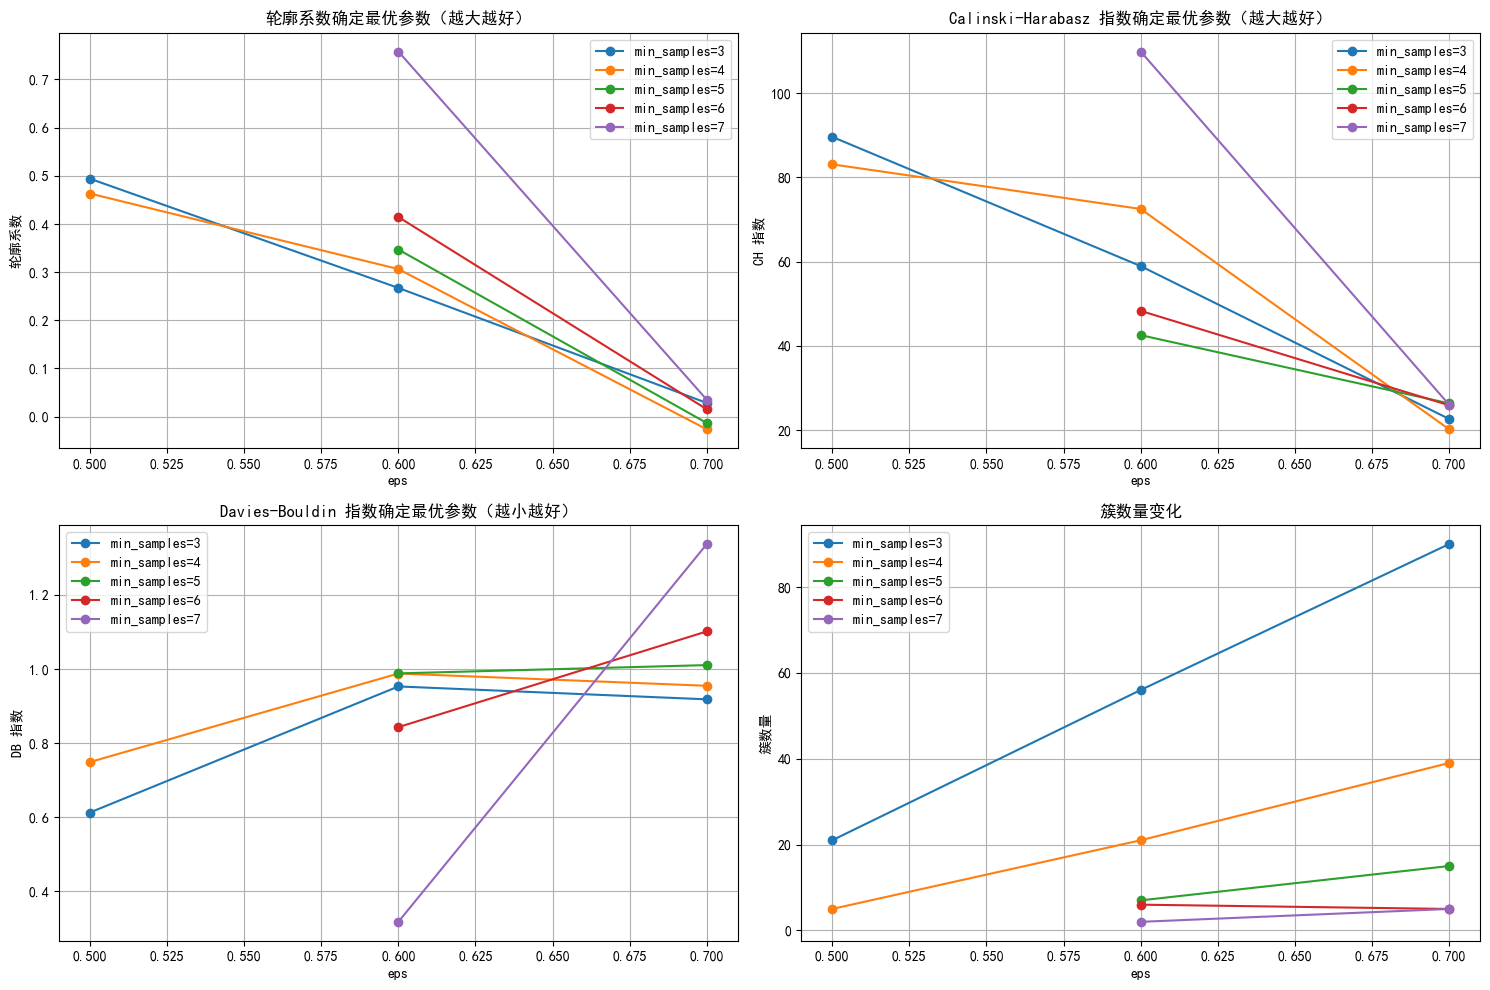

In [64]:
# 绘制评估指标图，增加点论文中的工作量，使文章更加的丰富且美观
plt.figure(figsize=(15,10))
# 轮廓系数
plt.subplot(2,2,1)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'],subset['silhouette'],marker='o',label = f'min_samples={min_samples}')
plt.title('轮廓系数确定最优参数（越大越好）')
plt.xlabel('eps')
plt.ylabel('轮廓系数')
plt.legend()
plt.grid(True)



# CH指数图
plt.subplot(2,2,2)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'],subset['ch_score'],marker='o',label = f'min_samples={min_samples}')
plt.title('Calinski-Harabasz 指数确定最优参数（越大越好）')
plt.xlabel('eps')
plt.ylabel('CH 指数')
plt.legend()
plt.grid(True)

# DB 指数
plt.subplot(2,2,3)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'],subset['db_score'],marker='o',label = f'min_samples={min_samples}')
plt.title('Davies-Bouldin 指数确定最优参数（越小越好）')
plt.xlabel('eps')
plt.ylabel('DB 指数')
plt.legend()
plt.grid(True)

# 簇数量图
plt.subplot(2,2,4)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'],subset['n_clusters'],marker='o',label = f'min_samples={min_samples}')
plt.title('簇数量变化')
plt.xlabel('eps')
plt.ylabel('簇数量')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

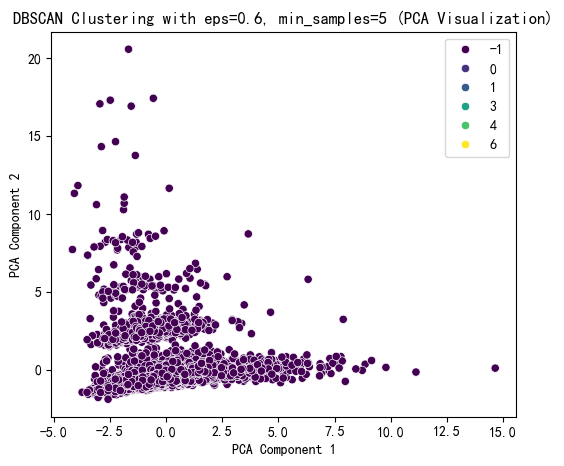

DBSCAN Cluster labels (eps=0.6,min_samples=5) added to X:
DBSCAN_Cluster
-1                7433
 0                  14
 2                  12
 3                  11
 5                  11
 6                   9
 1                   6
 4                   4
Name: count, dtype: int64


In [65]:
# 选择eps 和 min_samples值（根据图表选择最佳参数）
selected_eps = 0.6  
selected_min_samples = 5

# 使用选择的参数进行DBSCAN聚类
dbscan = DBSCAN(eps = selected_eps,min_samples = selected_min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)
X['DBSCAN_Cluster'] = dbscan_labels

# 使用PCA降维到2D进行可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN聚类结果可视化
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],hue=dbscan_labels,palette='viridis')
plt.title(f'DBSCAN Clustering with eps={selected_eps}, min_samples={selected_min_samples} (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 打印DBSCAN 聚类标签分布
print(f"DBSCAN Cluster labels (eps={selected_eps},min_samples={selected_min_samples}) added to X:")
print(X[['DBSCAN_Cluster']].value_counts())

## 层次聚类

Agglomerative Clustering 是一种自底向上的层次聚类方法，初始时每个样本是一个簇，然后逐步合并最相似的簇，直到达到指定的簇数量或满足停止条件。由于它需要指定簇数量（类似于 KMeans），我将通过测试不同的簇数量 n_clusters 来评估聚类效果，并使用轮廓系数（Silhouette Score）、CH 指数（Calinski-Harabasz Index）和 DB 指数（Davies-Bouldin Index）作为评估指标。

n_clusters=2, 轮廓系数: 0.303, CH 指数: 440.87, DB 指数: 3.240
n_clusters=3, 轮廓系数: 0.173, CH 指数: 399.10, DB 指数: 2.894
n_clusters=4, 轮廓系数: 0.195, CH 指数: 372.90, DB 指数: 2.652
n_clusters=5, 轮廓系数: 0.206, CH 指数: 361.07, DB 指数: 2.272
n_clusters=6, 轮廓系数: 0.223, CH 指数: 358.82, DB 指数: 2.153
n_clusters=7, 轮廓系数: 0.228, CH 指数: 361.72, DB 指数: 1.806
n_clusters=8, 轮廓系数: 0.214, CH 指数: 368.31, DB 指数: 1.625
n_clusters=9, 轮廓系数: 0.222, CH 指数: 377.70, DB 指数: 1.612
n_clusters=10, 轮廓系数: 0.228, CH 指数: 389.52, DB 指数: 1.443


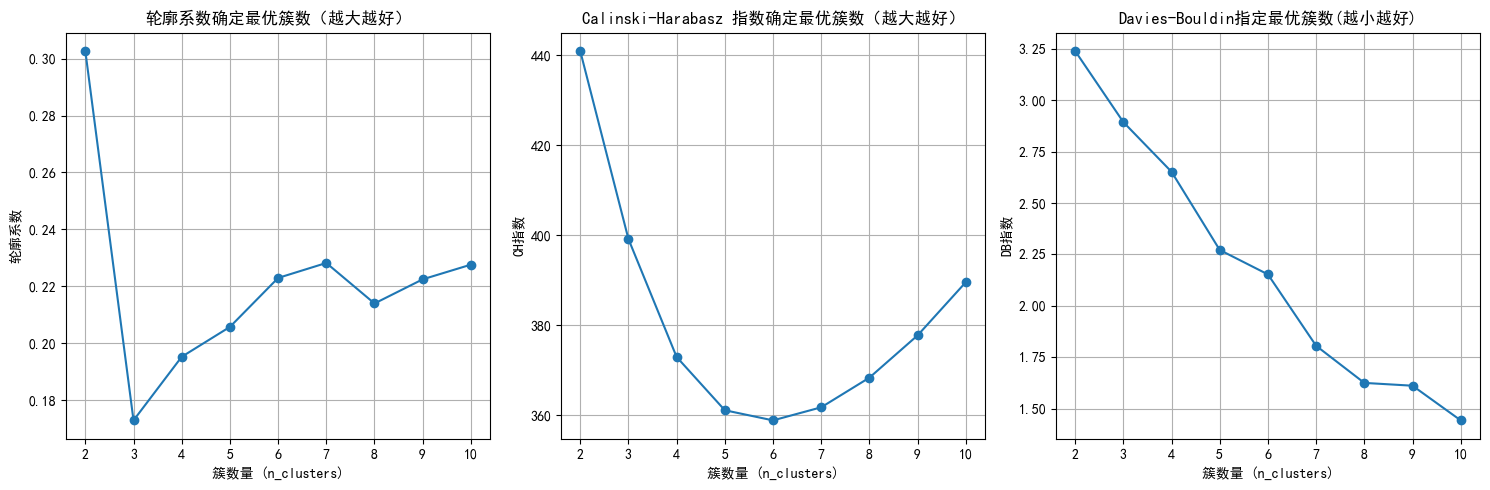

In [66]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 评估不同n_clusters下的指标
n_clusters_range = range(2,11)
silhouette_scores = []
ch_scores = []
db_scores = []

for n_clusters in n_clusters_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward')
    agglo_labels = agglo.fit_predict(X_scaled)

    # 计算评估指标
    silhouette = silhouette_score(X_scaled, agglo_labels)
    ch = calinski_harabasz_score(X_scaled, agglo_labels)
    db = davies_bouldin_score(X_scaled, agglo_labels)

    silhouette_scores.append(silhouette)
    ch_scores.append(ch)
    db_scores.append(db)

    print(f"n_clusters={n_clusters}, 轮廓系数: {silhouette:.3f}, CH 指数: {ch:.2f}, DB 指数: {db:.3f}")

# 绘制 评估指标图
plt.figure(figsize=(15,5))

# 轮廓系数图
plt.subplot(1,3,1)
plt.plot(n_clusters_range,silhouette_scores,marker = 'o')
plt.title('轮廓系数确定最优簇数（越大越好）')
plt.xlabel('簇数量 (n_clusters)')
plt.ylabel('轮廓系数')
plt.grid(True)

# CH指数图
plt.subplot(1,3,2)
plt.plot(n_clusters_range,ch_scores,marker = 'o')
plt.title('Calinski-Harabasz 指数确定最优簇数（越大越好）')
plt.xlabel('簇数量 (n_clusters)')
plt.ylabel('CH指数')
plt.grid(True)

# DB指数图
plt.subplot(1,3,3)
plt.plot(n_clusters_range,db_scores,marker = 'o')
plt.title('Davies-Bouldin指定最优簇数(越小越好)')
plt.xlabel('簇数量 (n_clusters)')
plt.ylabel('DB指数')
plt.grid(True)

plt.tight_layout()
plt.show()

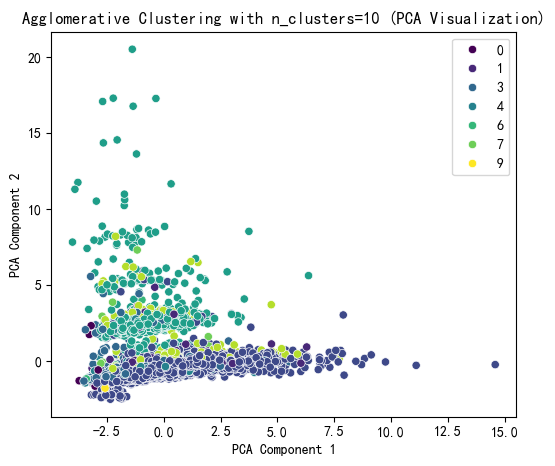

Agglomerative Cluster labels (n_clusters=10) added to X:
Agglo_Cluster
2                5217
5                 787
3                 690
8                 409
1                 212
4                  96
6                  34
9                  26
0                  21
7                   8
Name: count, dtype: int64


In [67]:
# 提示用户选择 n_clusters 值（这里可以根据图表选择最佳簇数）
selected_n_clusters = 10 # 示例值，根据图表调整

# 使用选择的簇数进行 Agglomerative Clustering 聚类
agglo = AgglomerativeClustering(n_clusters=selected_n_clusters, linkage='ward')
agglo_labels = agglo.fit_predict(X_scaled)
X['Agglo_Cluster'] = agglo_labels

# 使用 PCA 降维到 2D 进行可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Agglomerative Clustering 聚类结果可视化
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agglo_labels, palette='viridis')
plt.title(f'Agglomerative Clustering with n_clusters={selected_n_clusters} (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 打印 Agglomerative Clustering 聚类标签的分布
print(f"Agglomerative Cluster labels (n_clusters={selected_n_clusters}) added to X:")
print(X[['Agglo_Cluster']].value_counts())

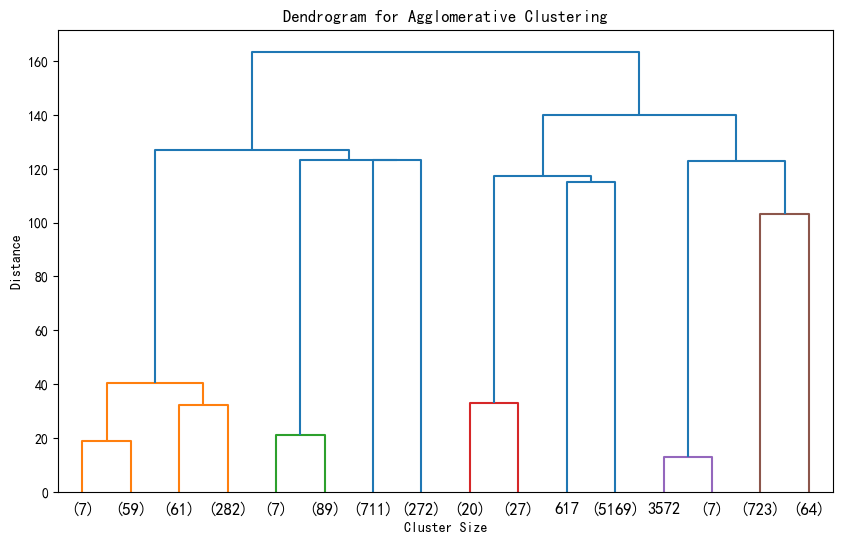

In [68]:
# 层次聚类的树状图可视化
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# 假设 X_scaled 是标准化后的数据
# 计算层次聚类的链接矩阵
Z = hierarchy.linkage(X_scaled, method='ward')  # 'ward' 是常用的合并准则

# 绘制树状图
plt.figure(figsize=(10, 6))
hierarchy.dendrogram(Z, truncate_mode='level', p=3)  # p 控制显示的层次深度
# hierarchy.dendrogram(Z, truncate_mode='level')  # 不用p这个参数，可以显示全部的深度
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
Index(['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak',
       'slope', 'ca', 'thal', 'target', 'sex_0', 'sex_1', 'fbs_0', 'fbs_1',
       'exang_0', 'exang_1'],
      dtype='object')
k=2, 惯性: 4059.37, 轮廓系数: 0.176, CH 指数: 58.48, DB 指数: 2.167
k=3, 惯性: 3590.99, 轮廓系数: 0.164, CH 指数: 52.51, DB 指数: 1.966
k=4, 惯性: 3128.44, 轮廓系数: 0.182, CH 指数: 54.78, DB 指数: 1.720
k=5, 惯性: 2991.57, 轮廓系数: 0.158, CH 指数: 46.23, DB 指数: 1.945
k=6, 惯性: 2871.74, 轮廓系数: 0.130, CH 指数: 40.88, DB 指数: 1.935
k=7, 惯性: 2718.83, 轮廓系数: 0.156, CH 指数: 38.63, DB 指数: 1.860
k=8, 惯性: 2609.43, 轮廓系数: 0.158, CH 指数: 36.15, DB 指数: 2.053
k=9, 惯性: 2522.74, 轮廓系数: 0.158, CH 指数: 33.87, DB 指数: 1.882
k=10, 惯性: 2477.22, 轮廓系数: 0.158, CH 指数: 31.16, DB 指数:

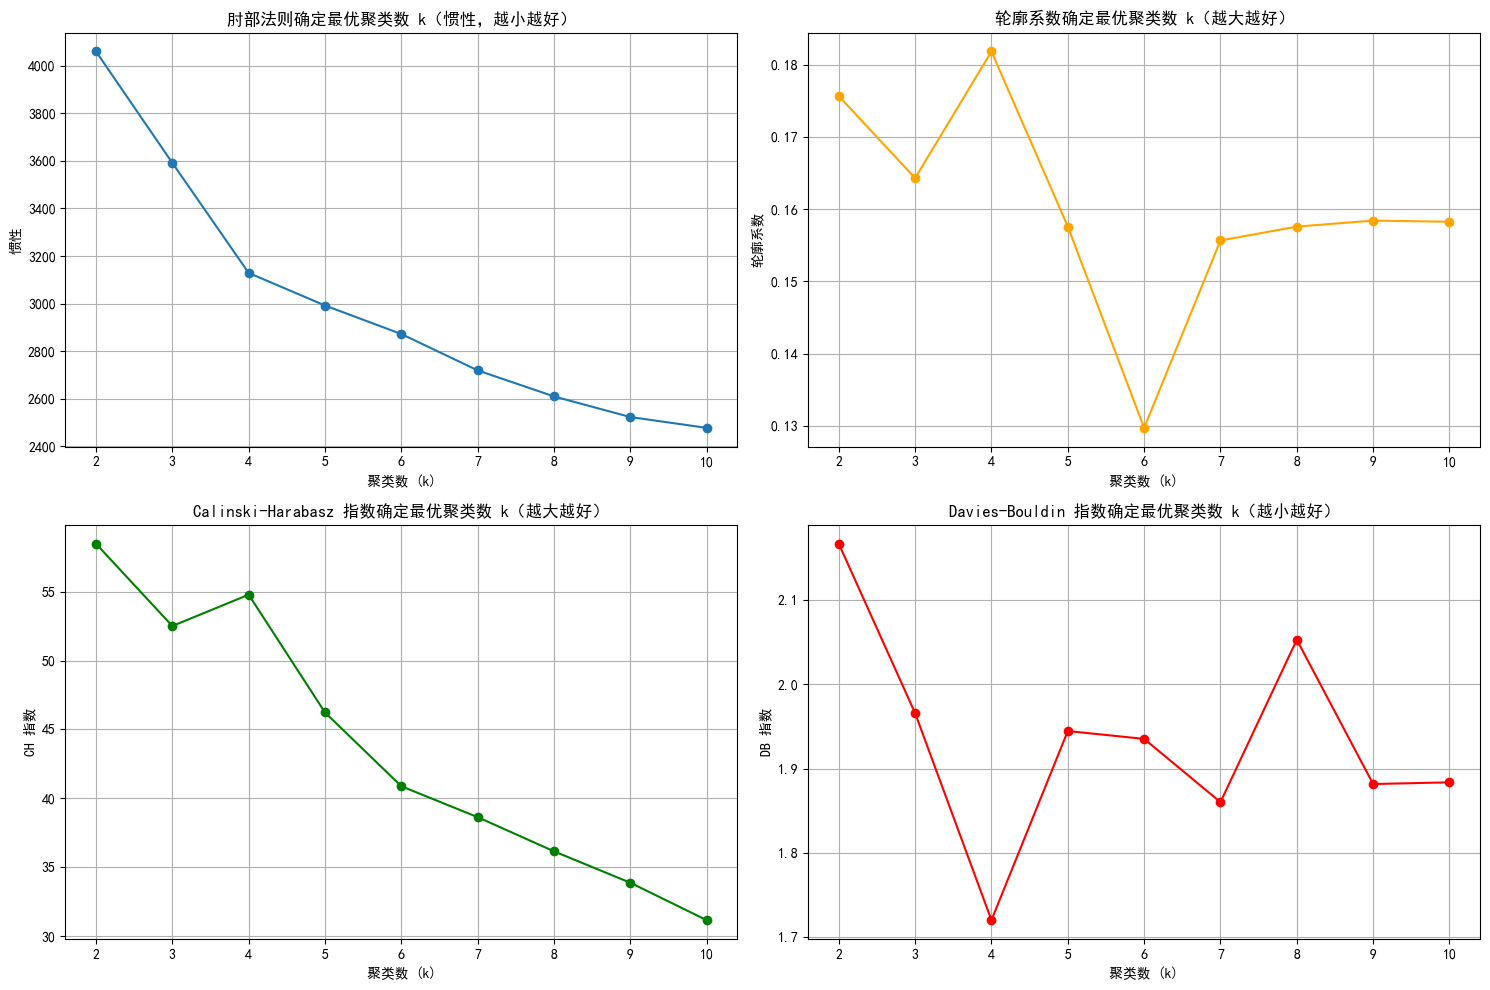

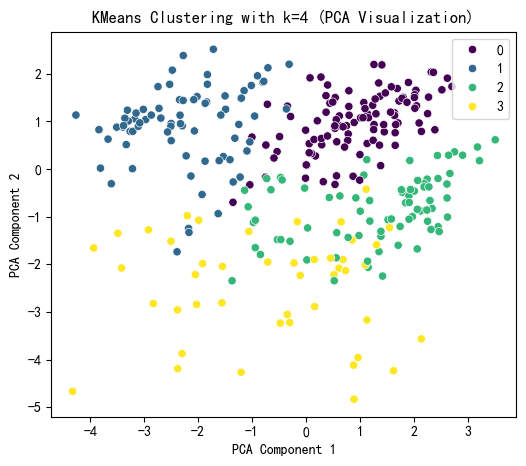

KMeans Cluster labels (k=4) added to X:
KMeans_Cluster
0                 105
2                  77
1                  76
3                  45
Name: count, dtype: int64
eps=0.3, min_samples=3, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.3, min_samples=4, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.3, min_samples=5, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.3, min_samples=6, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.3, min_samples=7, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.3, min_samples=8, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.3, min_samples=9, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.4, min_samples=3, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.4, min_samples=4, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.4, min_samples=5, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.4, min_samples=6, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.4, min_samples=7, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.4, min_samples=8, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.4, min_samples=9, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.5, min_samples=3, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.5, min_samples=4, 簇数: 0, 噪声点: 303, 无法计算评估指标
eps=0.5, min_samples=5, 簇数: 0, 

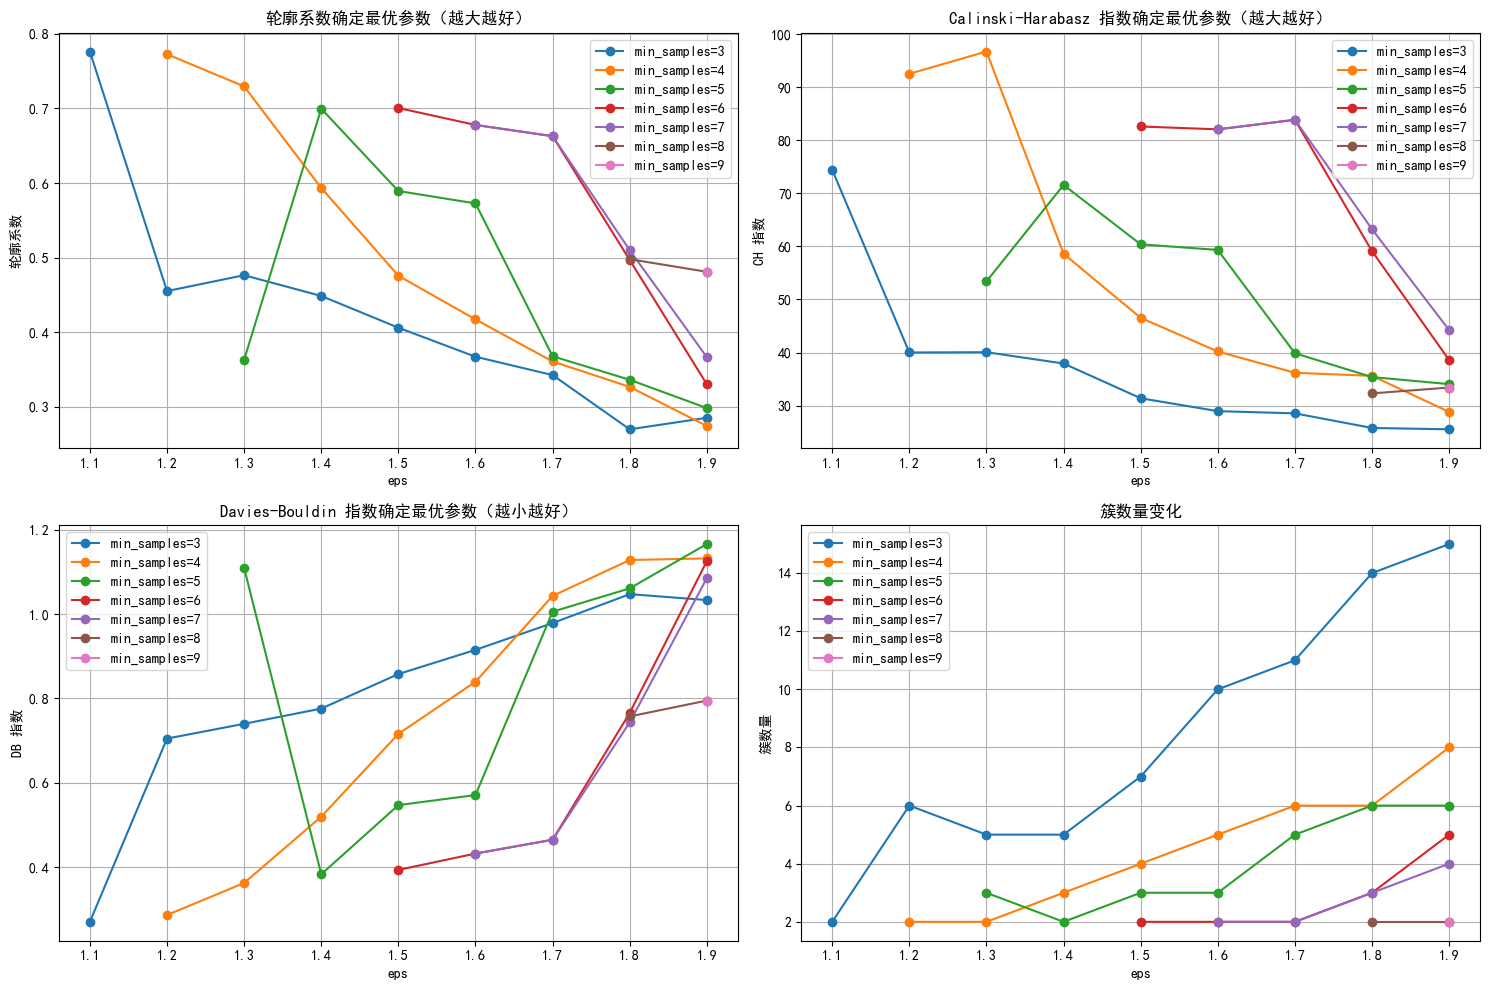

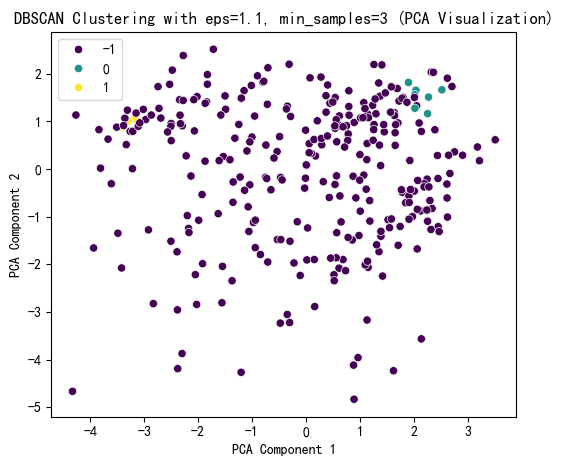

DBSCAN Cluster labels (eps=1.1, min_samples=3) added to X:
DBSCAN_Cluster
-1                293
 0                  7
 1                  3
Name: count, dtype: int64
n_clusters=2, 轮廓系数: 0.165, CH 指数: 52.25, DB 指数: 2.316
n_clusters=3, 轮廓系数: 0.190, CH 指数: 55.79, DB 指数: 1.790
n_clusters=4, 轮廓系数: 0.208, CH 指数: 57.96, DB 指数: 1.666
n_clusters=5, 轮廓系数: 0.215, CH 指数: 50.67, DB 指数: 1.398
n_clusters=6, 轮廓系数: 0.209, CH 指数: 45.51, DB 指数: 1.582
n_clusters=7, 轮廓系数: 0.175, CH 指数: 42.15, DB 指数: 1.805
n_clusters=8, 轮廓系数: 0.176, CH 指数: 39.50, DB 指数: 1.900
n_clusters=9, 轮廓系数: 0.181, CH 指数: 37.34, DB 指数: 1.785
n_clusters=10, 轮廓系数: 0.186, CH 指数: 35.48, DB 指数: 1.664


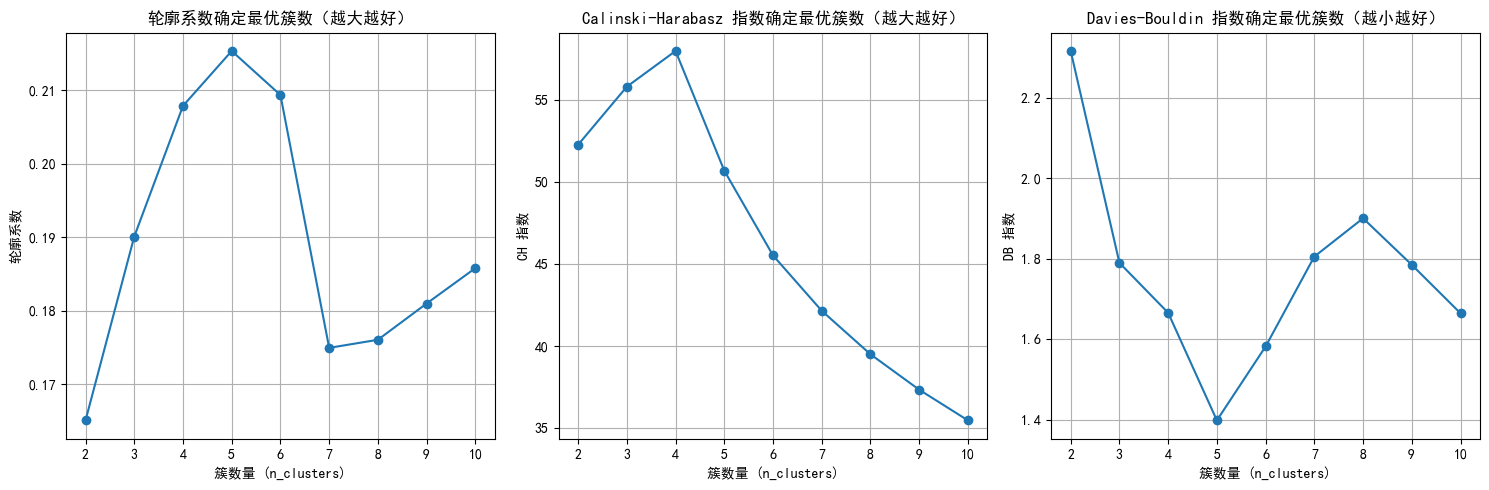

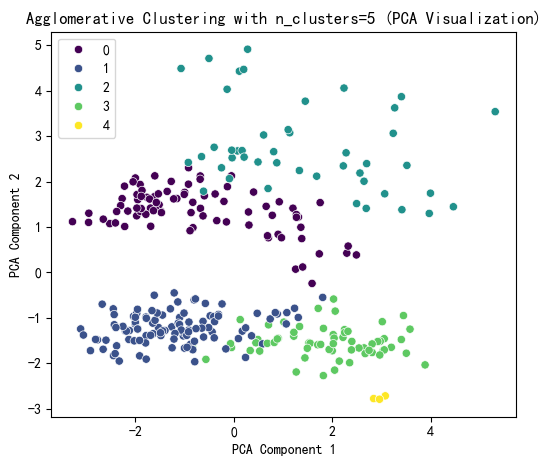

Agglomerative Cluster labels (n_clusters=5) added to X:
Agglo_Cluster
1                108
0                 84
3                 63
2                 45
4                  3
Name: count, dtype: int64


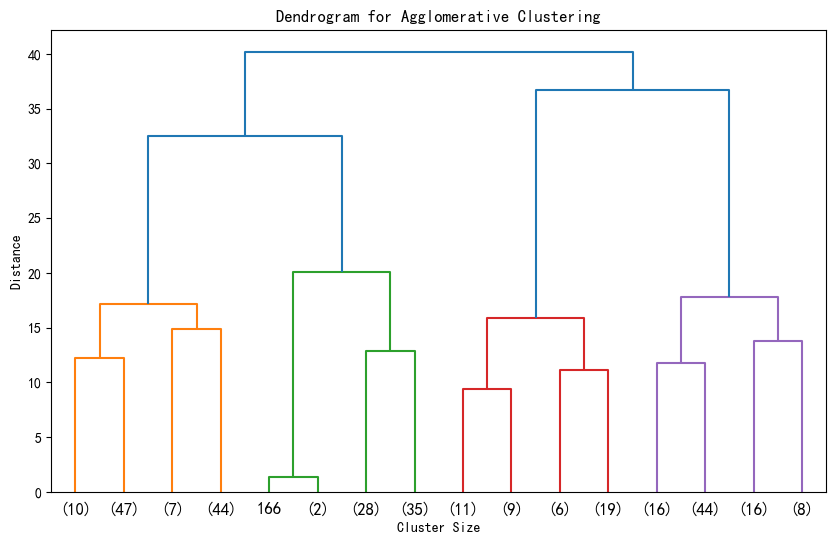

In [74]:
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('heart.csv')    #读取数据
print(data.columns)    #'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
# 'restecg', 'thalach','exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
#提取连续特征值
continuous_features = ['age','trestbps', 'chol', 'thalach','oldpeak']
print(continuous_features)    #打印出连续特征值的列名
#提取离散特征值
discrete_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal','target']
print(discrete_features)    #打印出离散特征值的列名

#使用映射字典进行转换
mapping_dict = {
    'cp':{0:0,1:1,2:2,3:3},
    'restecg':{0:0,1:1,2:2},
    'slope':{0:0,1:1,2:2},
    'thal':{0:0,1:1,2:2,3:3},
    'ca':{0:0,1:1,2:2,3:3,4:4}
}
for feature, mapping_dict in mapping_dict.items():    #遍历映射字典
    data[feature] = data[feature].map(mapping_dict)    #将映射字典中的值替换为原数据中的值

#对离散特征值进行独热编码
data = pd.get_dummies(data, columns=['sex', 'fbs','exang'])    #对离散特征值进行独热编码
print(data.columns)    #打印出数据的列名
data2 = pd.read_csv("heart.csv")    #读取数据
list_final = []    #新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:    #遍历数据的列名
    if i not in data2.columns:    #如果列名不在原数据的列名中
        list_final.append(i)    #将列名添加到列表中
for i in list_final:    #遍历列表中的列名
    data[i] = data[i].astype(int)    #将列名转换为int类型
#划分训练集和测试集
from sklearn.model_selection import train_test_split    #导入train_test_split函数
X = data.drop(['target'], axis=1)    #特征，axis=1表示按列删除
y = data['target']    #标签
# #按照8:2划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    #80%训练集，20%测试集
# print(X_train.shape)    #打印出训练集的形状
# print(X_test.shape)    #打印出测试集的形状
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# 便准化数据（聚类前通常需要标准化）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_range = range(2, 11)  # 尝试不同的簇数
inertia_scores = []  # 存储每个簇数对应的轮廓系数
silhouette_scores = []
ch_scores = []
db_scores = []

# 尝试不同的簇数
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  # 初始化KMeans模型
    kmeans_labels = kmeans.fit_predict(X_scaled)
    inertia_scores.append(kmeans.inertia_)  # 计算轮廓系数
    silhouette = silhouette_score(X_scaled, kmeans_labels)  # 轮廓系数
    silhouette_scores.append(silhouette)
    ch = calinski_harabasz_score(X_scaled, kmeans_labels)  # CH 指数
    ch_scores.append(ch)
    db = davies_bouldin_score(X_scaled, kmeans_labels)  # DB 指数
    db_scores.append(db)
    print(f"k={k}, 惯性: {kmeans.inertia_:.2f}, 轮廓系数: {silhouette:.3f}, CH 指数: {ch:.2f}, DB 指数: {db:.3f}")

plt.figure(figsize=(15, 10))

# 肘部法则图（Inertia）
plt.subplot(2, 2, 1)
plt.plot(k_range, inertia_scores, marker='o')
plt.title('肘部法则确定最优聚类数 k（惯性，越小越好）')
plt.xlabel('聚类数 (k)')
plt.ylabel('惯性')
plt.grid(True)

# 轮廓系数图
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('轮廓系数确定最优聚类数 k（越大越好）')
plt.xlabel('聚类数 (k)')
plt.ylabel('轮廓系数')
plt.grid(True)

# CH 指数图
plt.subplot(2, 2, 3)
plt.plot(k_range, ch_scores, marker='o', color='green')
plt.title('Calinski-Harabasz 指数确定最优聚类数 k（越大越好）')
plt.xlabel('聚类数 (k)')
plt.ylabel('CH 指数')
plt.grid(True)

# DB 指数图
plt.subplot(2, 2, 4)
plt.plot(k_range, db_scores, marker='o', color='red')
plt.title('Davies-Bouldin 指数确定最优聚类数 k（越小越好）')
plt.xlabel('聚类数 (k)')
plt.ylabel('DB 指数')
plt.grid(True)

plt.tight_layout()
plt.show()


# 提示用户选择 k 值
selected_k = 4

# 使用选择的 k 值进行 KMeans 聚类
kmeans = KMeans(n_clusters=selected_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
X['KMeans_Cluster'] = kmeans_labels

# 使用 PCA 降维到 2D 进行可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans 聚类结果可视化
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis')
plt.title(f'KMeans Clustering with k={selected_k} (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 打印 KMeans 聚类标签的前几行
print(f"KMeans Cluster labels (k={selected_k}) added to X:")
print(X[['KMeans_Cluster']].value_counts())

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns



# 评估不同 eps 和 min_samples 下的指标
# eps这个参数表示邻域的半径，min_samples表示一个点被认为是核心点所需的最小样本数。
# min_samples这个参数表示一个核心点所需的最小样本数。

eps_range = np.arange(0.3, 2.0, 0.1)  # 测试 eps 从 0.3 到 0.7
min_samples_range = range(3, 10)  # 测试 min_samples 从 3 到 7
results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        # 计算簇的数量（排除噪声点 -1）
        n_clusters = len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        # 计算噪声点数量
        n_noise = list(dbscan_labels).count(-1)
        # 只有当簇数量大于 1 且有有效簇时才计算评估指标
        if n_clusters > 1:
            # 排除噪声点后计算评估指标
            mask = dbscan_labels != -1
            if mask.sum() > 0:  # 确保有非噪声点
                silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
                ch = calinski_harabasz_score(X_scaled[mask], dbscan_labels[mask])
                db = davies_bouldin_score(X_scaled[mask], dbscan_labels[mask])
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': silhouette,
                    'ch_score': ch,
                    'db_score': db
                })
                print(f"eps={eps:.1f}, min_samples={min_samples}, 簇数: {n_clusters}, 噪声点: {n_noise}, "
                      f"轮廓系数: {silhouette:.3f}, CH 指数: {ch:.2f}, DB 指数: {db:.3f}")
        else:
            print(f"eps={eps:.1f}, min_samples={min_samples}, 簇数: {n_clusters}, 噪声点: {n_noise}, 无法计算评估指标")

# 将结果转为 DataFrame 以便可视化和选择参数
results_df = pd.DataFrame(results)

# 绘制评估指标图，增加点论文中的工作量
plt.figure(figsize=(15, 10))
# 轮廓系数图
plt.subplot(2, 2, 1)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples] # 
    plt.plot(subset['eps'], subset['silhouette'], marker='o', label=f'min_samples={min_samples}')
plt.title('轮廓系数确定最优参数（越大越好）')
plt.xlabel('eps')
plt.ylabel('轮廓系数')
plt.legend()
plt.grid(True)

# CH 指数图
plt.subplot(2, 2, 2)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['ch_score'], marker='o', label=f'min_samples={min_samples}')
plt.title('Calinski-Harabasz 指数确定最优参数（越大越好）')
plt.xlabel('eps')
plt.ylabel('CH 指数')
plt.legend()
plt.grid(True)

# DB 指数图
plt.subplot(2, 2, 3)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['db_score'], marker='o', label=f'min_samples={min_samples}')
plt.title('Davies-Bouldin 指数确定最优参数（越小越好）')
plt.xlabel('eps')
plt.ylabel('DB 指数')
plt.legend()
plt.grid(True)

# 簇数量图
plt.subplot(2, 2, 4)
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['n_clusters'], marker='o', label=f'min_samples={min_samples}')
plt.title('簇数量变化')
plt.xlabel('eps')
plt.ylabel('簇数量')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 选择 eps 和 min_samples 值（根据图表选择最佳参数）
selected_eps = 1.1  # 根据图表调整
selected_min_samples = 3# 根据图表调整

# 使用选择的参数进行 DBSCAN 聚类
dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)
X['DBSCAN_Cluster'] = dbscan_labels

# 使用 PCA 降维到 2D 进行可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN 聚类结果可视化
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='viridis')
plt.title(f'DBSCAN Clustering with eps={selected_eps}, min_samples={selected_min_samples} (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 打印 DBSCAN 聚类标签的分布
print(f"DBSCAN Cluster labels (eps={selected_eps}, min_samples={selected_min_samples}) added to X:")
print(X[['DBSCAN_Cluster']].value_counts())



import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 评估不同 n_clusters 下的指标
n_clusters_range = range(2, 11)  # 测试簇数量从 2 到 10
silhouette_scores = []
ch_scores = []
db_scores = []

for n_clusters in n_clusters_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  # 使用 Ward 准则合并簇
    agglo_labels = agglo.fit_predict(X_scaled)
    
    # 计算评估指标
    silhouette = silhouette_score(X_scaled, agglo_labels)
    ch = calinski_harabasz_score(X_scaled, agglo_labels)
    db = davies_bouldin_score(X_scaled, agglo_labels)
    
    silhouette_scores.append(silhouette)
    ch_scores.append(ch)
    db_scores.append(db)
    
    print(f"n_clusters={n_clusters}, 轮廓系数: {silhouette:.3f}, CH 指数: {ch:.2f}, DB 指数: {db:.3f}")

# 绘制评估指标图
plt.figure(figsize=(15, 5))

# 轮廓系数图
plt.subplot(1, 3, 1)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('轮廓系数确定最优簇数（越大越好）')
plt.xlabel('簇数量 (n_clusters)')
plt.ylabel('轮廓系数')
plt.grid(True)

# CH 指数图
plt.subplot(1, 3, 2)
plt.plot(n_clusters_range, ch_scores, marker='o')
plt.title('Calinski-Harabasz 指数确定最优簇数（越大越好）')
plt.xlabel('簇数量 (n_clusters)')
plt.ylabel('CH 指数')
plt.grid(True)

# DB 指数图
plt.subplot(1, 3, 3)
plt.plot(n_clusters_range, db_scores, marker='o')
plt.title('Davies-Bouldin 指数确定最优簇数（越小越好）')
plt.xlabel('簇数量 (n_clusters)')
plt.ylabel('DB 指数')
plt.grid(True)

plt.tight_layout()
plt.show()

# 提示用户选择 n_clusters 值（这里可以根据图表选择最佳簇数）
selected_n_clusters = 5 # 示例值，根据图表调整

# 使用选择的簇数进行 Agglomerative Clustering 聚类
agglo = AgglomerativeClustering(n_clusters=selected_n_clusters, linkage='ward')
agglo_labels = agglo.fit_predict(X_scaled)
X['Agglo_Cluster'] = agglo_labels

# 使用 PCA 降维到 2D 进行可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Agglomerative Clustering 聚类结果可视化
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agglo_labels, palette='viridis')
plt.title(f'Agglomerative Clustering with n_clusters={selected_n_clusters} (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 打印 Agglomerative Clustering 聚类标签的分布
print(f"Agglomerative Cluster labels (n_clusters={selected_n_clusters}) added to X:")
print(X[['Agglo_Cluster']].value_counts())

# 层次聚类的树状图可视化
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# 假设 X_scaled 是标准化后的数据
# 计算层次聚类的链接矩阵
Z = hierarchy.linkage(X_scaled, method='ward')  # 'ward' 是常用的合并准则

# 绘制树状图
plt.figure(figsize=(10, 6))
hierarchy.dendrogram(Z, truncate_mode='level', p=3)  # p 控制显示的层次深度
# hierarchy.dendrogram(Z, truncate_mode='level')  # 不用p这个参数，可以显示全部的深度
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()